In [2]:
suppressWarnings({
    library(tidyverse)
    library(DESeq2)
    library(limma)
    library(edgeR)
    library(ggVennDiagram)
    library(pheatmap)
    library(RColorBrewer)
    library(clusterProfiler)
    library(org.Hs.eg.db)
})

In [3]:
# set the file path
file_path <- "results/star_salmon/salmon.merged.gene_tpm.tsv"

# read the TSV file into a data frame
dat <- read_tsv(file_path) %>% drop_na()
dat <- dat %>% 
    mutate_at(vars(-c(1, 2)), as.integer)
# extract the first two letters of each column name as group
group <- substr(colnames(dat)[3:length(colnames(dat))], 1, 2)
# create a design table with the group information
design <- data.frame(Group = group)

# print the design table
print(design)

Rows: 62754 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, gene_name
dbl (26): CC_021_1, CC_023_1, CC_025_1, CC_026_1, CC_027_1, CC_029_1, CC_030...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


   Group
1     CC
2     CC
3     CC
4     CC
5     CC
6     CC
7     CC
8     CC
9     CC
10    CC
11    CC
12    CC
13    CC
14    CC
15    PD
16    PD
17    PD
18    PD
19    PD
20    PD
21    PD
22    PD
23    PD
24    PD
25    PD
26    PD


In [4]:
# create a DESeq2 object with the given parameters
dds <- DESeqDataSetFromMatrix(countData = dat[,3:length(colnames(dat))],
                              colData = design,
                              design = ~ Group)

# set the parameters
dds <- DESeq(dds, test = "Wald", fitType = "parametric",  minReplicatesForReplace = 7)

# extract the results table
res <- results(dds)
rownames(res) <- dat$gene_id
# filter the results table to get the DEGs
DEGs_deseq2 <- res[which(res$pvalue < 0.05 & abs(res$log2FoldChange) > 1),]

# print the DEGs
DEGs_deseq2
DEGs_genelist <- list(deseq = rownames(DEGs_deseq2))


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 45 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



log2 fold change (MLE): Group PD vs CC 
Wald test p-value: Group PD vs CC 
DataFrame with 117 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat     pvalue
                 <numeric>      <numeric> <numeric> <numeric>  <numeric>
ENSG00000005381   0.646267        1.66728  0.842899   1.97804 0.04792471
ENSG00000010030   1.908544       -1.49153  0.582421  -2.56091 0.01043995
ENSG00000067048   1.863486        1.76359  0.895801   1.96872 0.04898473
ENSG00000071082 256.635806        1.02738  0.391100   2.62690 0.00861658
ENSG00000087502   3.061873        1.08026  0.521979   2.06954 0.03849565
...                    ...            ...       ...       ...        ...
ENSG00000288851   4.718732        1.09358  0.498555   2.19350  0.0282715
ENSG00000289353   1.764691        1.29741  0.554455   2.33997  0.0192851
ENSG00000289548   0.877712       -2.17753  0.848516  -2.56628  0.0102796
ENSG00000290683   1.854220        1.17086  0.558087   2.09799  0.0359060
ENSG0000029

In [5]:
# create a DGEList object from the count data
dge <- DGEList(counts = dat[,3:length(colnames(dat))])

# create a design matrix object from the design table
design.matrix <- model.matrix(~0 + design$Group)

# use voom to transform the data and create a limma object
v <- voom(dge, design.matrix)

# fit the linear model
fit <- lmFit(v, design.matrix)

# calculate the empirical Bayes statistics
fit <- eBayes(fit)

# extract the results table
results <- topTable(fit, coef = 1, number = Inf)
rownames(results) <- dat$gene_id
# filter the results table to get the DEGs
DEGs_limma <- results[which(results$adj.P.Val < 0.05 & abs(results$logFC) > 1),]
DEGs_limma
# add the DEGs to the gene list
DEGs_genelist$limma <- rownames(DEGs_limma)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000259712,8.345609,8.338977,181.03828,1.128895e-39,1.564788e-39,79.34631
ENSG00000259713,10.642894,10.649257,146.17522,2.071129e-37,2.870779e-37,73.87800
ENSG00000259715,10.123313,10.247929,121.62543,1.823911e-35,2.528056e-35,69.22693
ENSG00000259717,12.055514,12.128155,116.92350,4.763243e-35,6.601862e-35,68.19422
ENSG00000259719,17.329762,17.119884,117.09247,4.598687e-35,6.373929e-35,68.14216
ENSG00000259720,18.818004,18.563910,114.22939,8.401845e-35,1.164471e-34,67.49363
ENSG00000259721,9.013128,9.143973,110.47897,1.893663e-34,2.624504e-34,66.81292
ENSG00000259722,15.615495,15.403906,99.82672,2.233044e-33,3.094798e-33,64.13011
ENSG00000259723,8.577612,8.520474,93.08474,1.223650e-32,1.695831e-32,62.48337


In [6]:
# create a DGEList object from the count data
dge <- DGEList(counts = dat[,3:length(colnames(dat))])

# create a design matrix object from the design table
design.matrix <- model.matrix(~0 + design$Group)

# calculate normalization factors
dge <- calcNormFactors(dge)

# estimate the dispersion
dge <- estimateDisp(dge, design.matrix)

# fit the generalized linear model
fit <- glmQLFit(dge, design.matrix)

# perform the hypothesis test
qlf <- glmQLFTest(fit, coef = 1)

# extract the results table
results <- topTags(qlf, n = Inf)
rownames(results$table) <- dat$gene_id

# filter the results table to get the DEGs
DEGs_edgeR <- results$table[which(results$table$FDR < 0.05 & abs(results$table$logFC) > 1),]

# print the DEGs
DEGs_edgeR
# add the DEGs to the gene list
DEGs_genelist$edgeR <- rownames(DEGs_edgeR)


,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003,-18.46780,2.129219,70101.50,3.910240e-52,1.259153e-47
ENSG00000000005,-18.55598,2.144643,67125.33,7.497641e-52,1.259153e-47
ENSG00000000419,-18.55759,2.105348,65412.87,1.104931e-51,1.259153e-47
ENSG00000000457,-18.69789,2.067910,64780.37,1.278365e-51,1.259153e-47
ENSG00000000460,-18.69588,2.037396,64611.13,1.329545e-51,1.259153e-47
ENSG00000000938,-18.69644,2.025861,64445.29,1.381818e-51,1.259153e-47
ENSG00000000971,-18.42733,2.159157,64214.51,1.458242e-51,1.259153e-47
ENSG00000001036,-18.47046,2.149675,62868.80,2.003768e-51,1.259153e-47
ENSG00000001084,-18.74626,2.046016,62368.50,2.258985e-51,1.259153e-47


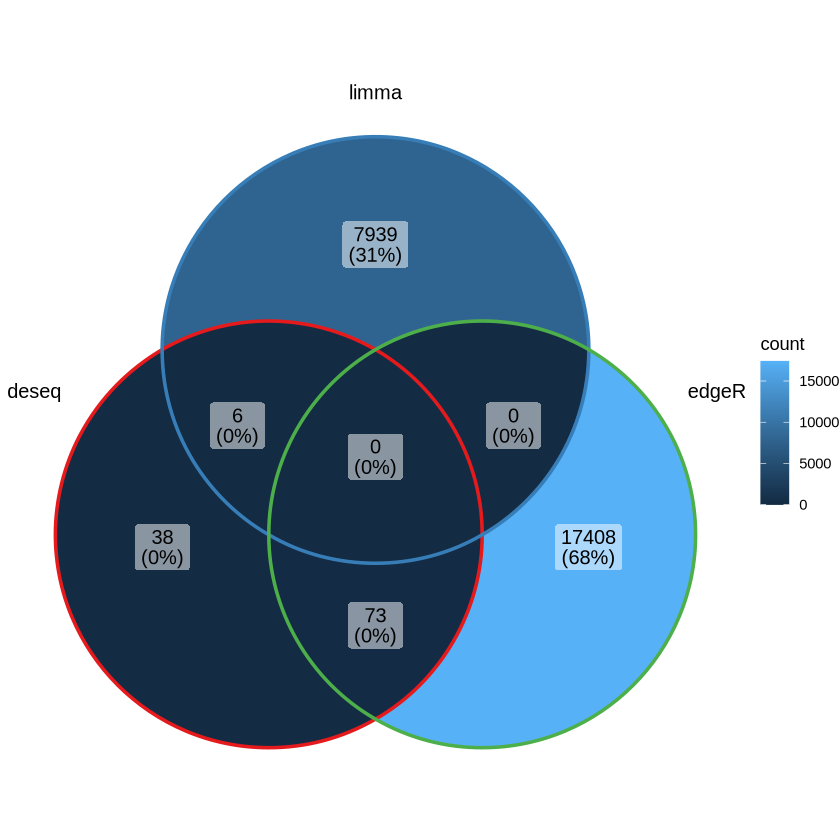

In [7]:
ggVennDiagram(DEGs_genelist) + scale_color_brewer(palette = "Set1")

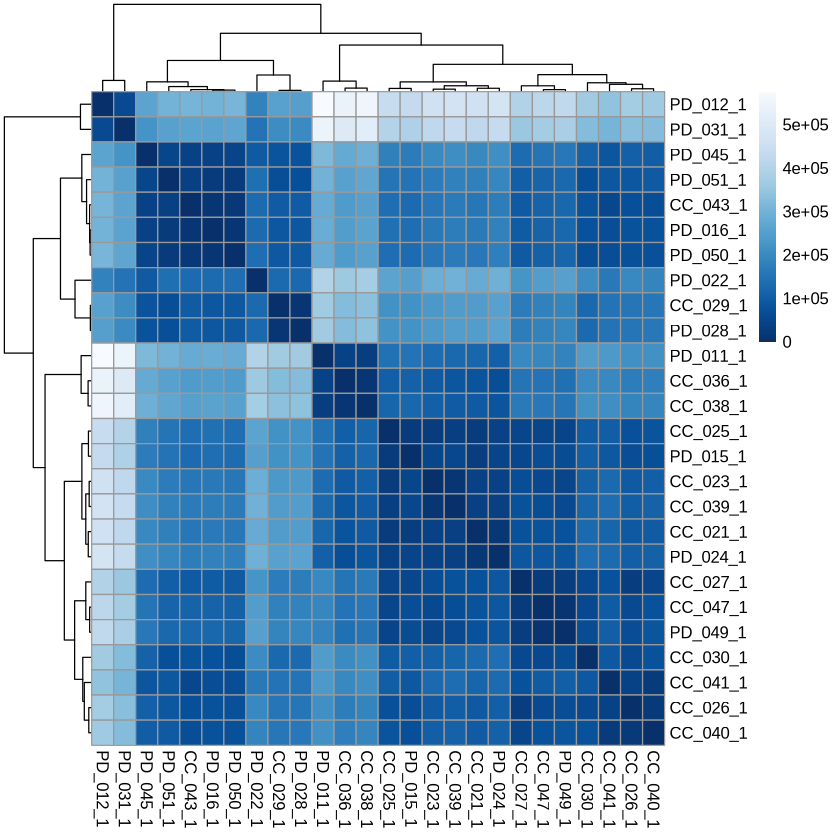

In [8]:
# calculate sample distances
sample_dists <- dist(t(dat[,3:length(colnames(dat))]))
sample_matrix <- as.matrix(sample_dists)
rownames(sample_matrix) <- colnames(sample_matrix) <- colnames(dat[,3:length(colnames(dat))])
colors <- colorRampPalette(rev(brewer.pal(9, "Blues")) )(255)
# visualize sample distances using pheatmap
pheatmap(sample_matrix, 
         color = colors,
         cluster_distance_rows = sample_dists,
         cluster_distance_cols = sample_dists)

limma和edgeR之间没有intersection，为测试用，只用deseq的DEGs

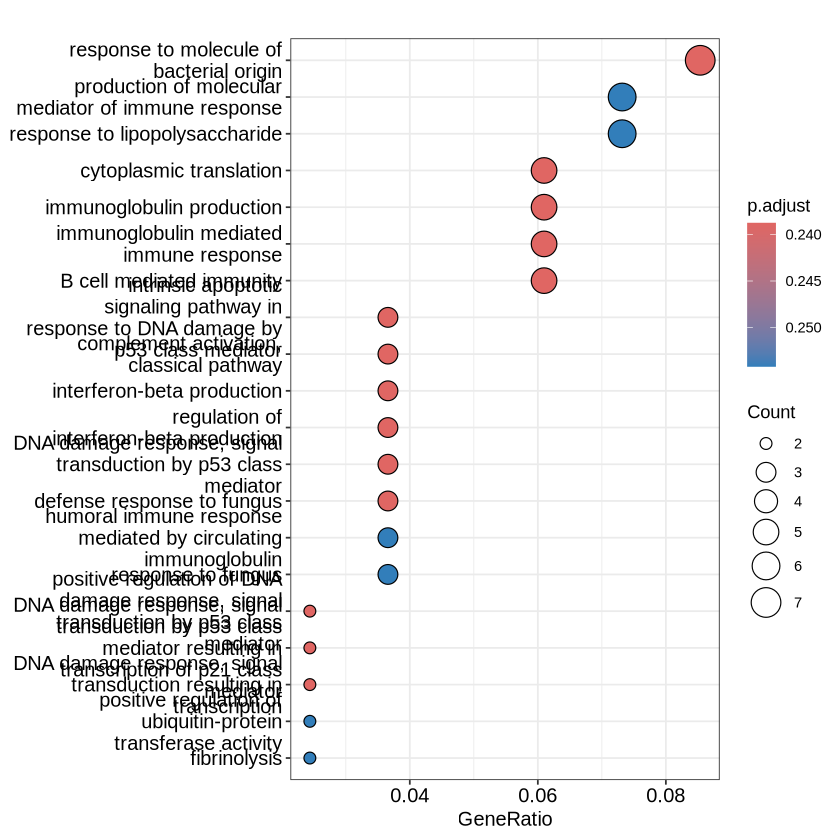

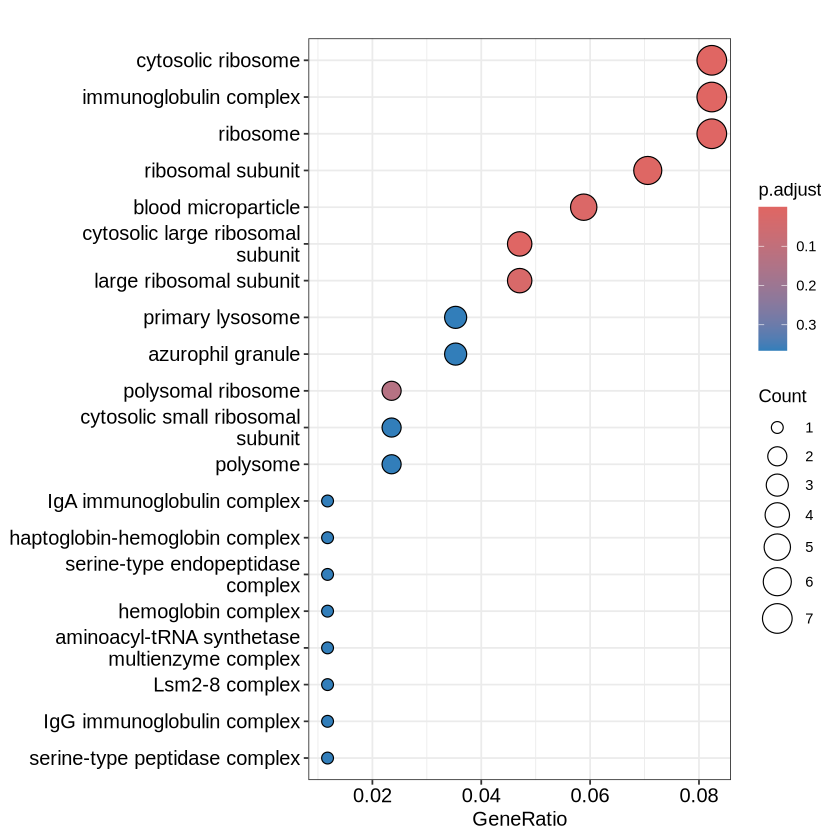

In [9]:
# get the intersection of gene_id in DEGs_genelist
gene_id_hub <- Reduce(intersect, DEGs_genelist)
gene_id_hub <- DEGs_genelist$deseq
# perform gene ontology enrichment analysis using enrichGO function
ego_bp <- enrichGO(gene_id_hub, OrgDb = org.Hs.eg.db, keyType = "ENSEMBL", ont = "BP", pvalueCutoff = 0.5, qvalueCutoff = 0.5, readable = TRUE)
# create a dotplot of the enriched terms
dotplot(ego_bp, showCategory = 20)
ego_cc <- enrichGO(gene_id_hub, OrgDb = org.Hs.eg.db, keyType = "ENSEMBL", ont = "CC", pvalueCutoff = 0.5, qvalueCutoff = 0.5, readable = TRUE)
# create a dotplot of the enriched terms
dotplot(ego_cc, showCategory = 20)
